In [1]:
import collections
import numpy as np
import nltk
from nltk.corpus import brown
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
from torch import optim
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
sentences = brown.sents()
corpus = [word.lower() for sentence in sentences for word in sentence]

# Calculate word frequencies
word_counts = collections.Counter(corpus)

# Remove words with frequency less than 5
filtered_corpus = [word for word in corpus if word_counts[word] >= 5]

# Create a vocabulary and word-to-index mapping
vocab = set(filtered_corpus)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

In [3]:
def get_context_windows(corpus_indices, context_size):
    context_pairs = []
    for i, word_idx in enumerate(corpus_indices):
        for j in range(max(0, i - context_size), min(len(corpus_indices), i + context_size + 1)):
            if i != j:
                context_pairs.append((word_idx, corpus_indices[j]))
    return context_pairs

def generate_examples(context_pairs, unigram_dist, num_negatives=1):
    positive_examples = []
    negative_examples = []
    labels = []
    
    for target, context in tqdm(context_pairs, desc="Generating examples"):
        positive_examples.append((target, context))
        labels.append(1)
        
        for _ in range(num_negatives):
            negative_context = np.random.choice(vocab_size, p=unigram_dist)
            negative_examples.append((target, negative_context))
            labels.append(0)
    
    examples = positive_examples + negative_examples
    return examples, labels

In [4]:
class CustomTextDataset(Dataset):

    def __init__(self, pkl_path='./examples_labels.pkl', context_size=2, num_negatives=1):
        self.pkl_path = pkl_path
        self.context_size = context_size
        self.num_negatives = num_negatives
        
        if os.path.exists(pkl_path):
            with open(pkl_path, 'rb') as f:
                examples, labels = pickle.load(f)
        else:
            corpus_indices = [word_to_idx[word] for word in filtered_corpus] 
            context_pairs = get_context_windows(corpus_indices, context_size)
            word_counts_filtered = collections.Counter(corpus_indices)
            total_count = sum(word_counts_filtered.values())
            unigram_dist = np.array([word_counts_filtered[i] for i in range(vocab_size)])
            unigram_dist = unigram_dist / total_count
            unigram_dist = unigram_dist ** (3/4)
            unigram_dist = unigram_dist / np.sum(unigram_dist)
            examples, labels = generate_examples(context_pairs, unigram_dist, num_negatives)
            with open(pkl_path, 'wb') as f:
                pickle.dump((examples, labels), f)
        
        self.examples_tensor = torch.tensor(examples)
        self.labels_tensor = torch.tensor(labels)

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        return self.examples_tensor[idx], self.labels_tensor[idx]

In [5]:
train_set = CustomTextDataset(pkl_path='./examples_labels.pkl', context_size=2, num_negatives=1)
trainloader = DataLoader(train_set, batch_size=8192)

In [6]:
train_data_iter = iter(trainloader)
next(train_data_iter)

[tensor([[ 6269, 12852],
         [ 6269, 12173],
         [12852,  6269],
         ...,
         [ 2241,  7317],
         [ 2241,  3655],
         [ 2241,  4791]]),
 tensor([1, 0, 1,  ..., 0, 1, 0])]

In [7]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300):
        super().__init__()
        self.vocab_size = vocab_size
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # Define x to be have a shape of [batch_size, 2]
    def forward(self, x):
        embed_input = self.input_embedding(x.T[0])
        embed_output = self.output_embedding(x.T[1])
        return (embed_input*embed_output).sum(dim=1)

In [8]:
model = Word2Vec(vocab_size, 300).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters())

# Training Loop

In [9]:
from tqdm.auto import tqdm

def loop_fn(dataset, dataloader, model, criterion, optimizer, device):
    model.train()
    cost = 0
    for feature, target in tqdm(dataloader):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output.float(), target.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

In [11]:
epochs = 20
train_cost = []
for i in range(epochs):
    cost = loop_fn(train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    
    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]: 4f} | ", end=" ")

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 1/20 | train_cost:  3.196429 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 2/20 | train_cost:  2.453560 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 3/20 | train_cost:  1.957354 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 4/20 | train_cost:  1.598714 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 5/20 | train_cost:  1.330474 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 6/20 | train_cost:  1.127300 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 7/20 | train_cost:  0.973192 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 8/20 | train_cost:  0.856605 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 9/20 | train_cost:  0.768585 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 10/20 | train_cost:  0.702197 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 11/20 | train_cost:  0.652133 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 12/20 | train_cost:  0.614352 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 13/20 | train_cost:  0.585761 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 14/20 | train_cost:  0.563957 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 15/20 | train_cost:  0.547152 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 16/20 | train_cost:  0.533985 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 17/20 | train_cost:  0.523495 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 18/20 | train_cost:  0.514967 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 19/20 | train_cost:  0.507868 |  

  0%|          | 0/1078 [00:00<?, ?it/s]

Epoch: 20/20 | train_cost:  0.501842 |  

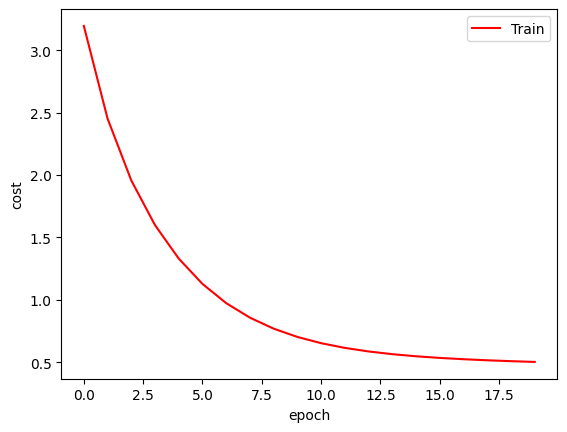

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_cost, 'r-', label='Train')
plt.xlabel('epoch'); plt.ylabel('cost'); plt.legend();

In [13]:
import os
os.makedirs('model', exist_ok=True)

# Save Model
torch.save(model.state_dict(), 'model/weights.pth')

In [15]:
# Load Model
model = Word2Vec(vocab_size, 300).to(device)
weights = torch.load('./model/weights.pth', map_location='cpu')
model.load_state_dict(weights)
model = model.to(device)

In [19]:
model.state_dict()

OrderedDict([('input_embedding.weight',
              tensor([[ 1.1929, -0.8577,  0.5896,  ...,  0.3192, -0.8154, -0.7437],
                      [-0.5141,  0.8937,  0.0691,  ...,  0.3755,  0.1248,  0.7826],
                      [ 0.3345, -0.1324,  0.2037,  ...,  1.0939,  1.1847,  0.2342],
                      ...,
                      [ 0.6928, -0.2059,  0.3588,  ...,  0.7543, -0.2326,  0.8926],
                      [ 0.6404,  1.1700,  0.6092,  ...,  0.7924, -0.0244,  0.0155],
                      [ 0.1891,  0.4559,  0.4195,  ...,  0.4719, -0.6693, -0.0195]],
                     device='cuda:0')),
             ('output_embedding.weight',
              tensor([[-0.0406, -0.2939, -0.7194,  ..., -1.6393,  0.2673,  0.7231],
                      [-0.3010, -0.5663,  1.4287,  ..., -0.4358,  1.0049,  0.9432],
                      [-0.5497,  0.3963, -0.4823,  ..., -0.3502,  0.1527,  0.4445],
                      ...,
                      [-0.4281, -0.5624, -1.0290,  ...,  0.2884, -0.